In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('combined_lab_testsV5.csv')
df.head()

,Sample ID,Patient Name,Gender,DOB,Test Name,Unit,Category,Result,DOS,Standard Test Name,Lab,Age,Outcome
0,118,Xalil Ahmad Mhamad,Male,16/04/1959,Blood Sugar,mg/dl,Diabetes Test,95,16/04/2023,Blood Sugar,Biolab,64.0,n
1,126,Dyar Omar,Male,16/04/1986,Blood Sugar,mg/dl,Diabetes Test,86,16/04/2023,Blood Sugar,Biolab,37.0,n
2,132,Fatah Mhamad Qadr,Male,16/04/1970,Blood Sugar,mg/dl,Diabetes Test,84,16/04/2023,Blood Sugar,Biolab,53.0,n
3,177,Sesna Qubad Anwar,Female,17/04/1973,Blood Sugar,mg/dl,Diabetes Test,84,17/04/2023,Blood Sugar,Biolab,50.0,n
4,179,Bayan Abdulla Abdurahman,Female,17/04/1981,Blood Sugar,mg/dl,Diabetes Test,96,17/04/2023,Blood Sugar,Biolab,42.0,n


In [3]:
# Removing unrealistic Ages and null values in Age
print(f"Original dataset size: {df.shape}")
df = df[(df['Age'] >= 0) & (df['Age'] <= 120)]
df = df.dropna(subset=['Age'])
print(f"Filtered dataset size: {df.shape}")

Original dataset size: (157361, 13)
Filtered dataset size: (157242, 13)


In [4]:
# change n => normal and an and bn => abnormal
df['Outcome'] = df['Outcome'].replace({'n': 'normal', 'an': 'abnormal', 'bn': 'abnormal'})
df['Outcome'].value_counts()

Outcome
normal      115277
abnormal     41965
Name: count, dtype: int64

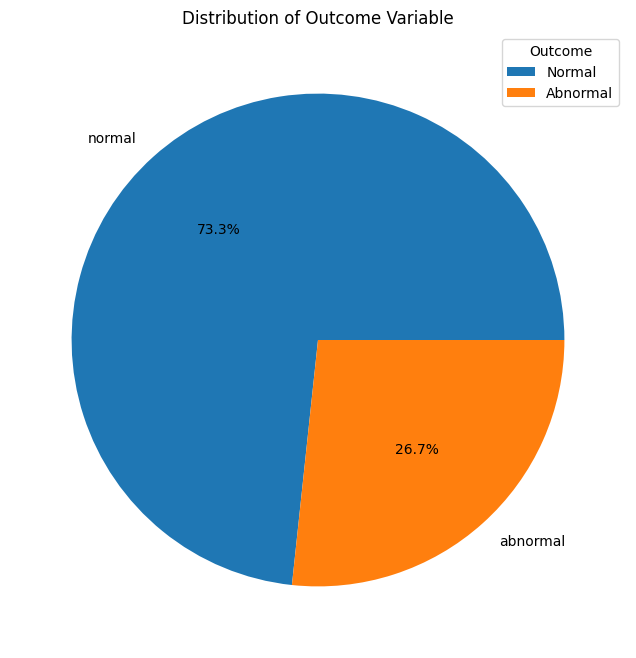

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
df['Outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Outcome Variable')
plt.ylabel('')  # Remove the default ylabel for pie charts
plt.legend(title='Outcome', labels=['Normal', 'Abnormal'], loc='upper right')
plt.show()


In [6]:

# Prepare the dataframe for classification and create dataframes for each test combination

# First, let's examine the structure of our main dataset
print("=== MAIN DATASET STRUCTURE ===")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Sample data:")
print(df.head())

# Check the outcome distribution
print(f"\n=== OUTCOME DISTRIBUTION ===")
print(df['Outcome'].value_counts())
print(f"Outcome percentages:")
print(df['Outcome'].value_counts(normalize=True) * 100)

# Check for null values in key columns
print(f"\n=== DATA QUALITY CHECK ===")
key_columns = ['Patient Name', 'Standard Test Name', 'Outcome', 'Result', 'Gender', 'Lab']
for col in key_columns:
    if col in df.columns:
        null_count = df[col].isnull().sum()
        print(f"{col}: {null_count} null values ({null_count/len(df)*100:.2f}%)")

# Get unique test names to understand what we're working with
print(f"\n=== AVAILABLE TESTS ===")
print(f"Total unique tests: {df['Standard Test Name'].nunique()}")
test_counts = df['Standard Test Name'].value_counts()
print(f"Top 10 most common tests:")
print(test_counts.head(10))

=== MAIN DATASET STRUCTURE ===
Shape: (157242, 13)
Columns: ['Sample ID', 'Patient Name', 'Gender', 'DOB', 'Test Name', 'Unit', 'Category', 'Result', 'DOS', 'Standard Test Name', 'Lab', 'Age', 'Outcome']
Sample data:
   Sample ID              Patient Name  Gender         DOB    Test Name  \
0        118        Xalil Ahmad Mhamad    Male  16/04/1959  Blood Sugar   
1        126                 Dyar Omar    Male  16/04/1986  Blood Sugar   
2        132         Fatah Mhamad Qadr    Male  16/04/1970  Blood Sugar   
3        177         Sesna Qubad Anwar  Female  17/04/1973  Blood Sugar   
4        179  Bayan Abdulla Abdurahman  Female  17/04/1981  Blood Sugar   

    Unit       Category Result         DOS Standard Test Name     Lab   Age  \
0  mg/dl  Diabetes Test     95  16/04/2023        Blood Sugar  Biolab  64.0   
1  mg/dl  Diabetes Test     86  16/04/2023        Blood Sugar  Biolab  37.0   
2  mg/dl  Diabetes Test     84  16/04/2023        Blood Sugar  Biolab  53.0   
3  mg/dl  Diabet

In [7]:
from fuzzywuzzy import fuzz
from collections import defaultdict
# Lets optimize more, adding one more constraint
# their first name should match exactly or mismatch only on one character.

def find_similar_names_v2(df, similarity_threshold=65):
    """
    Find similar patient names using fuzzy matching with first name constraint
    Returns groups of similar names that share the same LAB, DOB, and have similar first names
    """
    
    def first_names_similar(name1, name2):
        """Check if first names match exactly or have only one character difference"""
        first1 = name1.split()[0].lower()
        first2 = name2.split()[0].lower()
        
        # Exact match
        if first1 == first2:
            return True
        
        # Check if only one character difference
        if abs(len(first1) - len(first2)) > 1:
            return False
        
        # Count character differences
        differences = 0
        min_len = min(len(first1), len(first2))
        max_len = max(len(first1), len(first2))
        

        for i in range(min_len):
            if first1[i] != first2[i]:
                differences += 1
        
        # Add difference for length mismatch
        differences += max_len - min_len
        
        return differences <= 1
    
    # Group by LAB and DOB first to reduce comparison space
    grouped = df.groupby(['Lab', 'DOB'])
    similar_groups = []
    
    for (lab, dob), group in grouped:
        unique_names = group['Patient Name'].unique()
        
        if len(unique_names) > 1:
            processed_names = set()
            
            for i, name1 in enumerate(unique_names):
                if name1 in processed_names:
                    continue
                    
                current_group = [name1]
                processed_names.add(name1)
                
                for name2 in unique_names[i+1:]:
                    if name2 not in processed_names:
                        # Check both fuzzy similarity and first name constraint
                        similarity = fuzz.ratio(name1.lower(), name2.lower())
                        if (similarity >= similarity_threshold and 
                            first_names_similar(name1, name2)):
                            current_group.append(name2)
                            processed_names.add(name2)
                
                if len(current_group) > 1:
                    similar_groups.append({
                        'lab': lab,
                        'dob': dob,
                        'similar_names': current_group,
                        'count': len(current_group)
                    })
    
    return similar_groups

# Test the improved function
similar_name_groups_v2 = find_similar_names_v2(df, 85)

print(f"Found {len(similar_name_groups_v2)} groups of similar names with first name constraint")
print("\nFirst 20 groups:")
for i, group in enumerate(similar_name_groups_v2[:20]):
    print(f"\nGroup {i+1}:")
    print(f"  Lab: {group['lab']}")
    print(f"  DOB: {group['dob']}")
    print(f"  Similar names ({group['count']}): {group['similar_names']}")

d:\Research\mhmd_mawlawi\health_data\.venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Found 39 groups of similar names with first name constraint

First 20 groups:

Group 1:
  Lab: Biolab
  DOB: 1/6/2022
  Similar names (2): ['Kyan Ranj Jamal', 'Kian Ranj Jamal']

Group 2:
  Lab: Biolab
  DOB: 1/9/2022
  Similar names (2): ['Kyana Barham Latef', 'Dyana Barham Latef']

Group 3:
  Lab: Biolab
  DOB: 13/06/1962
  Similar names (2): ['Xanm Hamaamin Hamasalh', 'Xanm Hama Amin Hamasalih']

Group 4:
  Lab: Biolab
  DOB: 14/05/1993
  Similar names (2): ['Avin Taha Mhamad', 'Avin Taha Muhammed']

Group 5:
  Lab: Biolab
  DOB: 15/07/2009
  Similar names (2): ['Inas Hoshmand', 'Enas Hoshmand']

Group 6:
  Lab: Biolab
  DOB: 20/04/1957
  Similar names (2): ['Taiba Mahmud Maulud', 'Taiba Mahmud maulud']

Group 7:
  Lab: Biolab
  DOB: 20/04/1987
  Similar names (2): ['Hawsar Kamal Mhamad', 'Hawsar Kam,al Mhamad']

Group 8:
  Lab: Biolab
  DOB: 20/08/1991
  Similar names (2): ['Avan Abdulaziz Fatah', 'Avan Abdulazizi Fatah']

Group 9:
  Lab: Biolab
  DOB: 20/09/1982
  Similar names (2

In [8]:
fine_tuning = [95,90,85, 80, 75, 70, 65, 60]

for i in fine_tuning:
    similar_name_groups = find_similar_names_v2(df, i)
    print(f"Found {len(similar_name_groups)} groups of similar names with threshold {i}")

Found 20 groups of similar names with threshold 95
Found 35 groups of similar names with threshold 90
Found 39 groups of similar names with threshold 85
Found 46 groups of similar names with threshold 80
Found 51 groups of similar names with threshold 75
Found 62 groups of similar names with threshold 70
Found 76 groups of similar names with threshold 65
Found 90 groups of similar names with threshold 60


In [9]:
# Test the improved function
similar_name_groups_v2 = find_similar_names_v2(df, 70)

print(f"Found {len(similar_name_groups_v2)} groups of similar names with first name constraint")
print("\nGroups for 70% threshold:")
for i, group in enumerate(similar_name_groups_v2):
    print(f"\nGroup {i+1}:")
    print(f"  Lab: {group['lab']}")
    print(f"  DOB: {group['dob']}")
    print(f"  Similar names ({group['count']}): {group['similar_names']}")

Found 62 groups of similar names with first name constraint

Groups for 70% threshold:

Group 1:
  Lab: Biolab
  DOB: 1/11/2024
  Similar names (2): ['Ela Arian Ali', 'Ela Aryan']

Group 2:
  Lab: Biolab
  DOB: 1/12/2024
  Similar names (2): ['Shahan Shkar', 'Shahan Shkar Xalid']

Group 3:
  Lab: Biolab
  DOB: 1/6/2022
  Similar names (2): ['Kyan Ranj Jamal', 'Kian Ranj Jamal']

Group 4:
  Lab: Biolab
  DOB: 1/9/2022
  Similar names (2): ['Kyana Barham Latef', 'Dyana Barham Latef']

Group 5:
  Lab: Biolab
  DOB: 10/7/1971
  Similar names (2): ['Muhamad Abdulla', 'Muhamad Abdulla Hasan']

Group 6:
  Lab: Biolab
  DOB: 13/01/1967
  Similar names (2): ['Ali Mhamad Saed', 'Ali Muhammed saheed']

Group 7:
  Lab: Biolab
  DOB: 13/06/1962
  Similar names (2): ['Xanm Hamaamin Hamasalh', 'Xanm Hama Amin Hamasalih']

Group 8:
  Lab: Biolab
  DOB: 14/05/1993
  Similar names (2): ['Avin Taha Mhamad', 'Avin Taha Muhammed']

Group 9:
  Lab: Biolab
  DOB: 15/07/2009
  Similar names (2): ['Inas Hoshma

In [10]:
specials=[
          ['Inas Hoshmand', 'Enas Hoshmand'],
          ['Banan Ali', 'Bayan Aziz Ali'],
          ['kovan mahamad amanj', 'Rovan Muhamad Amanj'],
          ['Aiman Rebwar Muhammed', 'Aiman Rebwar Omar'],
          ['Dlin Aso Omar', 'Alin Aso Omar'],
          ['Muhamad Kosar Ahmad', 'Muhamad Sleman Muhamad'],
          ['Shirin Amin Mhamad', 'Shirin Abdulrahman Ahmad'],
          ['Shirin mhamad  Pirwais', 'Shirin Mhamad Rostam'],
          ['Shahla karim Mhamad', 'Shahla Mhamad Axa'],
          ['Shoxan Mhamad Faraj', 'shoxan Mhamad Amin'],
          ['naxshin tahir ahmad', 'Naxshin Salh Hama Murad'],
          ['Shirin faraj mhamad', 'shirin rahman ahmad'],
          ['swmaya jalal abdwlla', 'swmaya mahmud abdwlla'],
          ]

# lets go with 70 percent
# rename the second matching name with the first one for threshold of 70 in the df and do not do it when the name is one of the specials

similar_name_groups = find_similar_names_v2(df, 70)
# Create a set of special name pairs for faster lookup
special_pairs = set()
for pair in specials:
    special_pairs.add((pair[0].lower().strip(), pair[1].lower().strip()))
    special_pairs.add((pair[1].lower().strip(), pair[0].lower().strip()))  # Add reverse pair

print(f"Number of Unique names in the df BEFORE the renaming: {df['Patient Name'].nunique()}")

for group in similar_name_groups:
    if len(group['similar_names']) > 1:
        # Check if this is a special case that should not be renamed
        name1 = group['similar_names'][0].lower().strip()
        name2 = group['similar_names'][1].lower().strip()
        
        if (name1, name2) not in special_pairs:
            # Only rename if it's not a special case
            df.loc[df['Patient Name'] == group['similar_names'][1], 'Patient Name'] = group['similar_names'][0]

print(f"Number of Unique names in the df AFTER the renaming: {df['Patient Name'].nunique()}")

Number of Unique names in the df BEFORE the renaming: 33335
Number of Unique names in the df AFTER the renaming: 33286


In [11]:
# Task 1: Analyze test frequencies and remove tests with small frequencies

print("=== ANALYZING TEST FREQUENCIES ===")
print(f"Total records before filtering: {len(df):,}")

# Get test frequency distribution
test_frequency = df['Standard Test Name'].value_counts()
print(f"Total unique tests: {len(test_frequency)}")

# Show distribution of test frequencies
print(f"\n=== TEST FREQUENCY DISTRIBUTION ===")
print(f"Tests with 1-10 records: {(test_frequency <= 10).sum()}")
print(f"Tests with 11-50 records: {((test_frequency > 10) & (test_frequency <= 50)).sum()}")
print(f"Tests with 51-100 records: {((test_frequency > 50) & (test_frequency <= 100)).sum()}")
print(f"Tests with 101-500 records: {((test_frequency > 100) & (test_frequency <= 500)).sum()}")
print(f"Tests with 501-1000 records: {((test_frequency > 500) & (test_frequency <= 1000)).sum()}")
print(f"Tests with 1001-3000 records: {((test_frequency > 1000) & (test_frequency <= 3000)).sum()}")
print(f"Tests with >3000 records: {(test_frequency > 3000).sum()}")

# Define threshold for removing low-frequency tests
min_frequency_threshold = 1000
low_frequency_tests = test_frequency[test_frequency < min_frequency_threshold].index.tolist()

print(f"\n=== TESTS TO REMOVE (less than {min_frequency_threshold} records) ===")
print(f"Number of tests to remove: {len(low_frequency_tests)}")
print(f"Records to be removed: {test_frequency[test_frequency < min_frequency_threshold].sum():,}")

# Show the tests that will be removed
print(f"\nTests being removed:")
for i, test in enumerate(low_frequency_tests[:20], 1):
    count = test_frequency[test]
    print(f"{i:2d}. {test}: {count} records")
if len(low_frequency_tests) > 20:
    print(f"... and {len(low_frequency_tests) - 20} more tests")

# Remove low-frequency tests
df_filtered = df[~df['Standard Test Name'].isin(low_frequency_tests)].copy()

print(f"\n=== RESULTS AFTER FILTERING ===")
print(f"Records before filtering: {len(df):,}")
print(f"Records after filtering: {len(df_filtered):,}")
print(f"Records removed: {len(df) - len(df_filtered):,}")
print(f"Percentage of records retained: {len(df_filtered)/len(df)*100:.1f}%")

print(f"\nTests before filtering: {df['Standard Test Name'].nunique()}")
print(f"Tests after filtering: {df_filtered['Standard Test Name'].nunique()}")
print(f"Tests removed: {df['Standard Test Name'].nunique() - df_filtered['Standard Test Name'].nunique()}")

# Show the most common tests after filtering
print(f"\n=== TOP 20 MOST COMMON TESTS AFTER FILTERING ===")
filtered_test_freq = df_filtered['Standard Test Name'].value_counts()
for i, (test, count) in enumerate(filtered_test_freq.head(20).items(), 1):
    percentage = count / len(df_filtered) * 100
    print(f"{i:2d}. {test}: {count:,} ({percentage:.1f}%)")

# Update the main dataframe
df = df_filtered.copy()
print(f"\n✅ Dataset filtered successfully!")
print(f"📊 New dataset size: {len(df):,} records with {df['Standard Test Name'].nunique()} unique tests")

=== ANALYZING TEST FREQUENCIES ===
Total records before filtering: 157,242
Total unique tests: 216

=== TEST FREQUENCY DISTRIBUTION ===
Tests with 1-10 records: 76
Tests with 11-50 records: 34
Tests with 51-100 records: 19
Tests with 101-500 records: 40
Tests with 501-1000 records: 5
Tests with 1001-3000 records: 25
Tests with >3000 records: 17

=== TESTS TO REMOVE (less than 1000 records) ===
Number of tests to remove: 174
Records to be removed: 17,505

Tests being removed:
 1. Luteinizing Hormone: 849 records
 2. Testosterone: 839 records
 3. Prostate-Specific Antigen: 834 records
 4. HDL Cholesterol: 717 records
 5. Fecal Calprotectein Titer: 555 records
 6. Serum Albumin: 488 records
 7. Prothrombin Time: 486 records
 8. International Normalized Ratio: 481 records
 9. Serum Uric Acid: 469 records
10. C-Reactive Protein: 466 records
11. Thyroxine (T4): 445 records
12. Helicobacter pylori Antigen: 436 records
13. D-Dimer: 421 records
14. S.Zinc: 418 records
15. Bleeding Time: 384 rec

In [12]:
df.to_csv('df_cleaned.csv', index=False)